In [1]:
import torch
from torch import nn

class LogisticRegression(nn.Module):
  def __init__(self, inputSize, outputSize=1):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(inputSize, outputSize)
      
  def forward(self, x):
    return torch.sigmoid(self.linear(x))
      
  def hardPredict(self, X):
    return torch.round(self(X))


In [50]:
import math
import numpy as np

numChamps = 163
numRoles = 5

class SetElementProcessNetwork(nn.Module):
  def __init__(self, championEmbeddingSize = 32, roleEmbeddingSize = 3, outputSize = 10, nonLinearity = nn.ReLU):
    super(SetElementProcessNetwork, self).__init__()
    self.championEmbedding = nn.Embedding(numChamps+1, championEmbeddingSize)
    self.roleEmbedding = nn.Embedding(numRoles+1, roleEmbeddingSize)

    halfInputSize = math.floor((championEmbeddingSize+roleEmbeddingSize)/2)
    nn1 = nn.Linear(championEmbeddingSize+roleEmbeddingSize, halfInputSize)
    nn2 = nn.Linear(halfInputSize, outputSize)

    # nn.init.xavier_uniform_(nn1.weight, gain=np.sqrt(2))
    # nn.init.xavier_uniform_(nn2.weight, gain=np.sqrt(2))
    self.nn = nn.Sequential(
      nn1,
      nonLinearity(),
      nn2
    )

  def forward(self, champions, roles):
    championEmbeddings = self.championEmbedding(champions)
    roleEmbeddings = self.roleEmbedding(roles)

    combinedEmbeds = torch.cat((championEmbeddings, roleEmbeddings), dim=2)
    return self.nn(combinedEmbeds)

class DeepSetNeuralNet(nn.Module):
  def __init__(self, championEmbeddingSize = 32, roleEmbeddingSize =3, phiOutputSize = 10, nonLinearity = nn.ReLU):
    super(DeepSetNeuralNet, self).__init__()
    self.phi = SetElementProcessNetwork(championEmbeddingSize, roleEmbeddingSize, phiOutputSize, nn.Sigmoid)

    nn1 = nn.Linear(phiOutputSize*2, 5)
    nn2 = nn.Linear(5, 1)
    # nn.init.xavier_uniform_(nn1.weight, gain=np.sqrt(2))
    # nn.init.xavier_uniform_(nn2.weight, gain=np.sqrt(2))
    self.nn = nn.Sequential(
      nn1,
      nonLinearity(),
      nn2,
      nn.Sigmoid()
    )

  def forward(self, X):
    champions = X[:,:10]
    roles = X[:,10:]

    blueChampions = champions[:,:5]
    blueRoles = roles[:,:5]

    redChampions = champions[:,5:]
    redRoles = roles[:,5:]

    blueTeamEmbeddings = self.phi(blueChampions, blueRoles)
    redTeamEmbeddings = self.phi(redChampions, redRoles)

    # rho (aggregation function) is just sum TODO: try other agg functions later 
    blueTeamAgg = torch.sum(blueTeamEmbeddings, dim=1)
    redTeamAgg = torch.sum(redTeamEmbeddings, dim=1)
    combinedAgg = torch.cat((blueTeamAgg, redTeamAgg), dim=1)

    return self.nn(combinedAgg)

  def hardPredict(self, X):
    return torch.round(self(X))

In [2]:
import numpy as np

class EmbeddingNeuralNet(nn.Module):
    def __init__(self, championEmbeddingSize, roleEmbeddingSize, hiddenNNSize, nonLinearity = nn.ReLU):
      super(EmbeddingNeuralNet, self).__init__()
      numChamps = 163
      numRoles = 5

      # we use 1-indexing, we need to add 1 to the number of champions for padding because apparently this is common practice
      self.championEmbedding = nn.Embedding(numChamps+1, championEmbeddingSize)
      self.roleEmbedding = nn.Embedding(numRoles+1, roleEmbeddingSize)
      
      self.buildNN(championEmbeddingSize, roleEmbeddingSize, hiddenNNSize, nonLinearity)
    
    def buildNN(self, championEmbeddingSize, roleEmbeddingSize, hiddenNNSize, nonLinearity):
      # layerSizes = [championEmbeddingSize + roleEmbeddingSize] + hiddenNNSize + [1]
      layerSizes = [10*(championEmbeddingSize + roleEmbeddingSize)] + hiddenNNSize + [1]

      layers = []
      for inSize, outSize in zip(layerSizes[:-1], layerSizes[1:]):
        lin = nn.Linear(inSize, outSize)
        nn.init.xavier_uniform_(lin.weight, gain=np.sqrt(2))
        layers.append(lin)
        layers.append(nonLinearity())
      
      layers.pop(-1)
      layers.append(nn.Sigmoid())

      self.nn = nn.Sequential(*layers)

    def forward(self, X):
      champions = X[:,:10]
      roles = X[:,10:]

      champEmbeddings = self.championEmbedding(champions)
      roleEmbeddings = self.roleEmbedding(roles)

      combinedEmbeds = torch.cat((champEmbeddings, roleEmbeddings), dim=2)
      # combinedEmbedsSum = torch.sum(combinedEmbeds, dim=1)
      combinedEmbedsFlat = torch.flatten(combinedEmbeds, start_dim=1)
      test = self.nn(combinedEmbedsFlat)
      return test

    def hardPredict(self, X):
      return torch.round(self(X))

In [57]:
import pickle
import numpy as np
import json
from cassiopeia import data as LeagueData
from sklearn.model_selection import train_test_split

with open("../tarball_data/champions.json", "rb") as f:
    championData = json.load(f)["data"]
roles = ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]

championToIndexMap = {list(championData.keys())[i].lower(): i+1 for i in range(len(championData.keys()))}
roleToIndexMap = {roles[i]: i+1 for i in range(len(roles))}
numChamps = 163
numRoles = len(roles)

def getDataOneHot(match = "match_data_subset.pkl", data = None):
  if data is None:
    with open(f"../data/{match}", "rb") as f:
      matchData = pickle.load(f)
  else:
    matchData = data
  X = np.zeros((len(matchData), numChamps * 2 * numRoles))
  y = np.zeros((len(matchData), 1))

  for i, match in enumerate(matchData):
    players = np.array([team["participants"] for team in match["teams"]]).flatten()
    for player in players:
      teamIndex = 0 if player["side"] == LeagueData.Side.blue else numChamps*numRoles
      champIndex = championToIndexMap[player["championName"].lower()]-1 # -1 because champions use 1-indexing
      roleIndex = roleToIndexMap[player["teamPosition"]]-1 if player["teamPosition"] != "" else getUnknownPosition(players)  # -1 because roles use 1-indexing
      featureIndex = teamIndex + roleIndex*numChamps+champIndex
      X[i, featureIndex] = 1
    y[i] = did_blue_win(match) 

  return X, y

def getDataEmbeddings(match = "match_data_subset.pkl", data = None):
  if data is None:
    with open(f"../data/{match}", "rb") as f:
      matchData = pickle.load(f)
  else:
    matchData = data
  X = np.zeros((len(matchData), 20), dtype=int)
  y = np.zeros((len(matchData), 1), dtype=int)

  for i, match in enumerate(matchData):
    teamA, teamB = match["teams"]
    teamBlue, teamRed = [teamA, teamB] if teamA["side"] == LeagueData.Side.blue else [teamB, teamA]

    roleIndex = 10
    for j, player in enumerate(teamBlue["participants"]):
      X[i, j] = championToIndexMap[player["championName"].lower()]
      X[i, j+roleIndex] = roleToIndexMap[player["teamPosition"]] if player["teamPosition"] != "" else getUnknownPosition(teamBlue["participants"])
    
    teamIndex = 5
    for j, player in enumerate(teamRed["participants"]):
      X[i, j+teamIndex] = championToIndexMap[player["championName"].lower()]
      X[i, j+roleIndex+teamIndex] = roleToIndexMap[player["teamPosition"]] if player["teamPosition"] != "" else getUnknownPosition(teamRed["participants"])
    
    y[i] = teamBlue["isWinner"]
  
  return X, y


def did_blue_win(match):
  team_1, team_2 = match["teams"]
  if team_1["side"] == LeagueData.Side.blue:
    return team_1["isWinner"]
  return team_2["isWinner"] 

def getUnknownPosition(players):
  positionCount = np.zeros(numRoles)
  for player in players :
    if player["teamPosition"] != "":
      positionCount[roleToIndexMap[player["teamPosition"]]-1] += 1
  return np.argmin(positionCount)

def getTrainValData():
  with open("../data/match_data.pkl", "rb") as f:
    matchData = pickle.load(f)
  trainData, valData = train_test_split(matchData, test_size=0.1129, random_state=42)

  return trainData, valData

def trainTestSplit(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1273, random_state=42)
  return X_train, X_test, y_train, y_test

In [3]:
def getLossAndAcc(model, criterion, X, y, X_to_int = False):
  X_tensor = torch.from_numpy(X).float() if not X_to_int else torch.from_numpy(X).int()
  y_hat =model(X_tensor)
  loss= criterion(y_hat, torch.from_numpy(y).float())
  correct = (y_hat.round() == torch.from_numpy(y).float()).float()
  acc = correct.mean()

  return loss.item(), acc.item(), correct.sum().item()

def loadResults(name):
  with open (f"../results/{name}.json", 'r') as f:
    return json.load(f)

def plotAccuracyBargraph(results,
                          xValues, 
                          xLabel, 
                          yLabel, 
                          title, 
                          saveName = None, 
                          trainAcc = None, 
                          testAcc = None,
                          yLim = None,
                          trainAccLabel = "Train Accuracy",
                          testAccLabel = "Test Accuracy"):
  import matplotlib.pyplot as plt
  if trainAcc is None:
    trainAcc = list()
    testAcc = list()
    for result in results:
      trainAcc.append(result["trainClassification"][-1])
      testAcc.append(result["testClassification"][-1])
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  barWidth = 0.25
  plt.bar([i-barWidth/2 for i in range(len(xValues))], trainAcc, width=barWidth, label=trainAccLabel)
  plt.bar([i+barWidth/2 for i in range(len(xValues))], testAcc, width=barWidth, label=testAccLabel)
  plt.xticks(range(len(xValues)), xValues, rotation=45)
  if yLim is not None:
    plt.ylim(yLim)
  plt.legend()
  plt.title(title)
  if saveName is not None:
    plt.savefig(f"../plots/bar-graphs/{saveName}.png", bbox_inches='tight', pad_inches=0.1)
  plt.show()

  
  

In [5]:
train, val = getTrainValData()
X, y = getDataOneHot(data=train)
X_train, X_test, y_train, y_test = trainTestSplit(X, y)


In [7]:
### Model 1: Logistic Regression
n,d = X_train.shape
model_full = LogisticRegression(d)
model_early = LogisticRegression(d)

criterion = nn.BCELoss()

model_full.load_state_dict(torch.load("../models/log_reg_model_full.pt", map_location=torch.device('cpu')))
model_full.eval()

model_early.load_state_dict(torch.load("../models/log_reg_model_early.pt", map_location=torch.device('cpu')))
model_early.eval()

loss_full_train, acc_full_train, num_correct = getLossAndAcc(model_early, criterion, X_train, y_train)
loss_full_test, acc_full_test, num_correct = getLossAndAcc(model_early, criterion, X_test, y_test)

print(f"Full Model: Train Loss: {loss_full_train: .4f}")
print(f"Full Model: Test Loss: {loss_full_test: .4f}")
print(f"Full Model: Train Acc: {acc_full_train: .4f}")
print(f"Full Model: Test Acc: {acc_full_test: .4f}")

X_val, y_val = getDataOneHot(data=val)
loss_full_val, acc_full_val, num_correct = getLossAndAcc(model_full, criterion, X_val, y_val)

print(f"Full Model: Val Loss: {loss_full_val: .4f}")
print(f"Full Model: Val Acc: {acc_full_val: .4f}")
print(f"Full Model: Val Correct: {num_correct: .4f}")

Full Model: Train Loss:  0.6808
Full Model: Test Loss:  0.6862
Full Model: Train Acc:  0.5701
Full Model: Test Acc:  0.5631
Full Model: Val Loss:  0.6919
Full Model: Val Acc:  0.5337
Full Model: Val Correct:  1601.0000


In [8]:
import pickle
### model 2: random forest
model = pickle.load(open("../models/random_forest.pkl", 'rb'))

c:\Python38\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
print(model.n_estimators)
score = model.score(X_val,y_val)
print(score, score*len(y_val))

200
0.521 1563.0


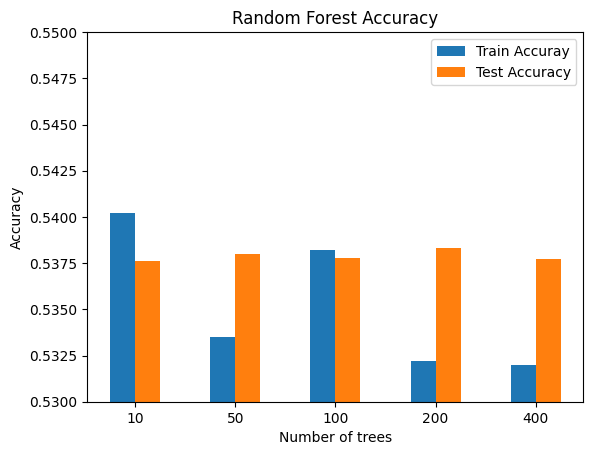

In [52]:
plotAccuracyBargraph({}, 
                     ["10", "50", "100", "200", "400"], 
                     "Number of trees", 
                     "Accuracy", 
                     "Random Forest Accuracy", 
                     saveName="randomForestAcc", 
                     trainAcc=[0.5402, 0.5335, 0.5382, 0.5322, 0.5320], 
                     testAcc=[0.5376, 0.5380, 0.5378, 0.5383, 0.5377],
                     yLim=(0.53, 0.55))

In [44]:
### model 3: naive bayes
model = pickle.load(open("../models/naive_bayes.pkl", 'rb'))
score = model.score(X_val,y_val)
print(score, score*len(y_val))

0.526 1578.0


c:\Python38\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator BernoulliNB from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


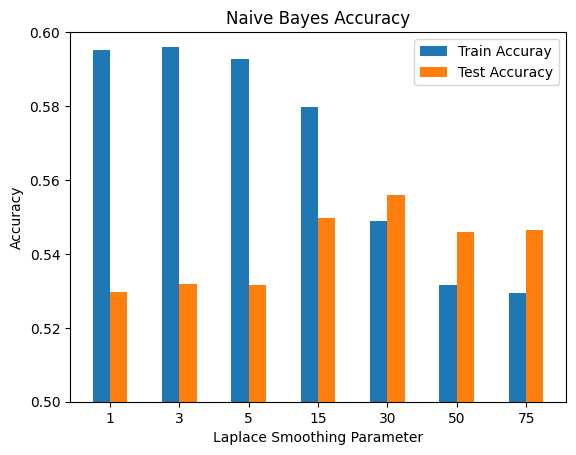

In [47]:
plotAccuracyBargraph({}, 
                     ["1", "3", "5", "15", "30", "50", "75"], 
                     "Laplace Smoothing Parameter", 
                     "Accuracy", 
                     "Naive Bayes Accuracy", 
                     saveName="naiveBayesAcc", 
                     trainAcc=[0.5952, 0.5960, 0.5928, 0.5797, 0.5490, 0.5317, 0.5294], 
                     testAcc=[0.5298, 0.5318, 0.5315, 0.5498, 0.5558, 0.5458, 0.5465],
                     yLim=(0.5, 0.6))

In [58]:
### model 5: neural network embeddings
X_val, y_val = getDataEmbeddings(data=val)
champEmbedSize = 50 
roleEmbedSize = 3 
hiddenNNSize = [100, 10]
nonlinearity = nn.Sigmoid

model = EmbeddingNeuralNet(champEmbedSize, roleEmbedSize, hiddenNNSize, nonlinearity)

for name in ["ReLU", "Sigmoid_EARLY", "Sigmoid_FULL", "Tanh"]:
    model.load_state_dict(torch.load(f"../models/embed_net_{name}.pt", map_location=torch.device('cpu')))
    model.eval()
    loss, acc, num_correct = getLossAndAcc(model, criterion, X_val, y_val, True)
    print(f"{name}: Val Loss: {loss: .4f}")
    print(f"{name}: Val Acc: {acc: .4f}")
    print(f"{name}: Val Correct: {num_correct: .4f}")


ReLU: Val Loss:  3.2862
ReLU: Val Acc:  0.5210
ReLU: Val Correct:  1563.0000
Sigmoid_EARLY: Val Loss:  0.6902
Sigmoid_EARLY: Val Acc:  0.5343
Sigmoid_EARLY: Val Correct:  1603.0000
Sigmoid_FULL: Val Loss:  0.6923
Sigmoid_FULL: Val Acc:  0.5210
Sigmoid_FULL: Val Correct:  1563.0000
Tanh: Val Loss:  4.6471
Tanh: Val Acc:  0.5210
Tanh: Val Correct:  1563.0000


In [23]:
results = list()
for name in ["FULL-ReLU", "EARLY-Sigmoid", "FULL-Tanh"]:
    result = json.load(open(f"../results/embeddedNet-{name}.json", 'r'))
    results.append(result)
    finalTrainLoss = result["train"][-1]
    finalTestLoss = result["test"][-1]
    finalTrainAcc = result["trainClassification"][-1]
    finalTestAcc = result["testClassification"][-1]
    print(f"{name}: Train Loss: {finalTrainLoss: .4f}")
    print(f"{name}: Test Loss: {finalTestLoss: .4f}")
    print(f"{name}: Train Acc: {finalTrainAcc: .4f}")
    print(f"{name}: Test Acc: {finalTestAcc: .4f}")

FULL-ReLU: Train Loss:  0.0601
FULL-ReLU: Test Loss:  1.3211
FULL-ReLU: Train Acc:  1.0000
FULL-ReLU: Test Acc:  0.5198
EARLY-Sigmoid: Train Loss:  0.6859
EARLY-Sigmoid: Test Loss:  0.6866
EARLY-Sigmoid: Train Acc:  0.5485
EARLY-Sigmoid: Test Acc:  0.5558
FULL-Tanh: Train Loss:  0.0758
FULL-Tanh: Test Loss:  1.5325
FULL-Tanh: Train Acc:  0.9995
FULL-Tanh: Test Acc:  0.5102


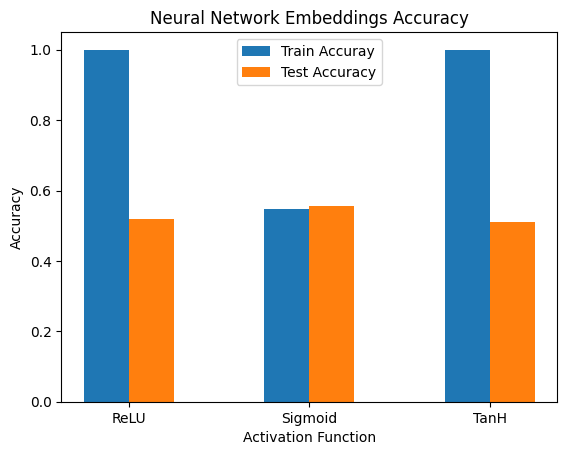

In [49]:
plotAccuracyBargraph(results, ["ReLU", "Sigmoid", "TanH"], "Activation Function", "Accuracy", "Neural Network Embeddings Accuracy", "embeddingNetAccuracy")

In [51]:
### model 6: deep set neural network
result = json.load(open(f"../results/deepSetNet3-EARLY_lr_0.001.json", 'r'))
trainLoss = result["train"][-1]
testLoss = result["test"][-1]
trainAcc = result["trainClassification"][-1]
testAcc = result["testClassification"][-1]

print(f"Deep Set: Train Loss: {trainLoss: .4f}")
print(f"Deep Set: Train Acc: {trainAcc: .4f}")
print(f"Deep Set: Test Acc: {testAcc: .4f}")

Deep Set: Train Loss:  0.6881
Deep Set: Test Loss:  0.6871
Deep Set: Train Acc:  0.5413
Deep Set: Test Acc:  0.5465


In [61]:
X_val, y_val = getDataEmbeddings(data=val)
champEmbedSize = 32 
roleEmbedSize = 3
outputSize= 10

# sub_model = SetElementProcessNetwork(champEmbedSize, roleEmbedSize, outputSize, nonLinearity=nn.Sigmoid)
model = DeepSetNeuralNet(champEmbedSize, roleEmbedSize, outputSize, nonLinearity=nn.Sigmoid)
# model.phi = sub_model

model.load_state_dict(torch.load(f"../models/deep_set_net_EARLY3.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [62]:
loss, acc, num_correct = getLossAndAcc(model, criterion, X_val, y_val, True)
print(f"Deep Set: Val Loss: {loss: .4f}")
print(f"Deep Set: Val Acc: {acc: .4f}")
print(f"Deep Set: Val Correct: {num_correct: .4f}")

Deep Set: Val Loss:  0.6921
Deep Set: Val Acc:  0.5210
Deep Set: Val Correct:  1563.0000


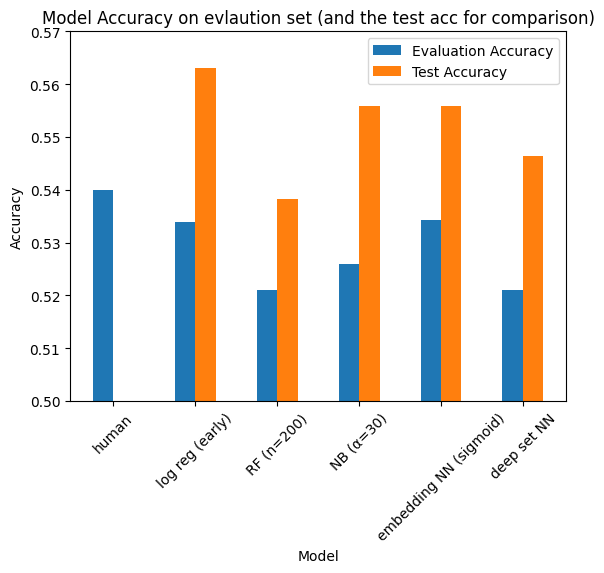

In [5]:
X = ["human", "log reg (early)", "RF (n=200)", "NB (α=30)", "embedding NN (sigmoid)", "deep set NN"]
evalAcc = [0.5400, 0.5340, 0.5210, 0.5260, 0.5343, 0.5210]
testAcc = [0, 0.5631, 0.5383, 0.5558, 0.5558, 0.5465]

plotAccuracyBargraph({}, 
                     X, 
                     "Model", 
                     "Accuracy", 
                     "Model Accuracy on evlaution set (and the test acc for comparison)", 
                     "modelAccuracyEval", 
                     trainAcc=evalAcc, 
                     testAcc=testAcc, 
                     yLim=(0.5, 0.57),
                     trainAccLabel="Evaluation Accuracy",
                     testAccLabel="Test Accuracy")
